# Kursinis. Mašininio mokymo laiko eilučių duomenų augmentacijos metodai
Programų sistemų studentas Armantas Pikšrys

## Mount data

In [1]:
!pip install torchvision

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print(gpu_devices)
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import backend as K
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv1D, BatchNormalization, AveragePooling1D, Dropout, Flatten
from keras.layers import LSTM, Dense
from keras import layers
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [6]:
# Set the window size
window_size = 640

# Directory where your files are located
data_dir = "./drive/MyDrive/kursinis/WeightDataCleaned"  # Replace with the actual directory path

In [7]:
# Initialize empty lists for signals and labels
signals = []
labels = []

In [9]:
# Iterate over files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_dir, filename)
        if float(filename.split("_")[0]) == 0:
            weight_label = float(0.5)
        else:
            weight_label = float(filename.split("_")[0])

        # Load CSV data
        data = pd.read_csv(file_path)

         # Create signals using a sliding window
        num_rows = len(data)
        step_size = 128

        for i in range(0, num_rows - window_size + 1, step_size):
            window_data = data.iloc[i:i+window_size]
            signals.append(window_data.values)
            labels.append(weight_label)

In [12]:
# Convert the lists to NumPy arrays
signals_array = np.array(signals)
labels_array = np.array(labels)

In [14]:
label_encoder = LabelEncoder()
labels_array = label_encoder.fit_transform(labels_array)

In [16]:
unique_labels, counts = np.unique(labels_array, return_counts=True)
print("Unique Labels:", unique_labels)
print("Counts:", counts)
print(signals_array.shape)

Unique Labels: [0 1 2 3 4]
Counts: [187 189 201 213 209]
(999, 640, 3)


In [23]:
N = signals_array.shape[0]
N_train = int(N*0.7)
N_val = int(N*0.9)

N_train, N_val, N

(699, 899, 999)

In [24]:
np.random.seed(seed=123)
arr = np.arange(N)
np.random.shuffle(arr)

arr.shape

(999,)

In [26]:
x_train = np.load('./drive/MyDrive/kursinis/DataNumpy/data_x_640-128_train.npy')
y_train = np.load('./drive/MyDrive/kursinis/DataNumpy/data_y_640-128_train.npy')./
x_test = np.load('./drive/MyDrive/kursinis/DataNumpy/data_x_640-128_test.npy')
y_test = np.load('./drive/MyDrive/kursinis/DataNumpy/data_y_640-128_test.npy')
x_val = np.load('./drive/MyDrive/kursinis/DataNumpy/data_x_640-128_val.npy')
y_val = np.load('./drive/MyDrive/kursinis/DataNumpy/data_y_640-128_val.npy')

In [27]:
mu = np.mean(signals_array[arr[:N_train]])
va = np.std(signals_array[arr[:N_train]])

In [28]:
print(mu)
print(va)

698.4988853123509
395.59220120613065


In [31]:
x_train = (x_train - mu)/va
x_val = (x_val - mu)/va
x_test = (x_test - mu)/va

n_classes = len(np.unique(y_train))

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, n_classes

((699, 640, 3), (699,), (200, 640, 3), (200,), (100, 640, 3), (100,), 5)

In [33]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.0921875,
 1: 1.059090909090909,
 2: 0.9985714285714286,
 3: 0.9708333333333333,
 4: 0.9019354838709678}

In [38]:
# Function to add Laplace noise to a single signal
def add_laplace_noise(signal, scale=0.01):
    noise = np.random.laplace(scale=scale, size=signal.shape)
    return signal + noise

In [39]:
def add_laplace_noise_to_array(signal_array_values, signal_array_targets, scale=0.01, augmentation_multiplier=1):
    combined_array = signal_array_values
    combined_targets = signal_array_targets

    for i in range(augmentation_multiplier):
        noisy_array = signal_array_values.copy()

        # Apply Laplace noise to each signal in the array
        for i in range(noisy_array.shape[0]):
            for j in range(noisy_array.shape[2]):
                noisy_array[i, :, j] = add_laplace_noise(noisy_array[i, :, j])

        # Append the Laplace-noised signals to x_train
        combined_array = np.vstack([combined_array, noisy_array])

        # Update labels accordingly
        targets_original = signal_array_targets.copy()
        combined_targets = np.concatenate([combined_targets, targets_original])

    # Shuffle the combined data (regular + noised)
    shuffle_indices = np.random.permutation(combined_array.shape[0])
    combined_array = combined_array[shuffle_indices, :]
    combined_targets = combined_targets[shuffle_indices]

    return combined_array, combined_targets

In [40]:
# Function to add drift augmentation to a single signal
def add_drift(signal, scale=0.01):
    num_points = signal.shape[0]
    time = np.arange(num_points)
    drift = np.random.normal(scale=scale, size=num_points)
    return signal + drift

In [41]:
def add_drift_to_array(signal_array_values, signal_array_targets, scale=0.01, augmentation_multiplier=1):
    combined_array = signal_array_values
    combined_targets = signal_array_targets

    for i in range(augmentation_multiplier):
        drifted_array = signal_array_values.copy()

        # Apply drift augmentation to each signal in the array
        for i in range(drifted_array.shape[0]):
            for j in range(drifted_array.shape[2]):
                drifted_array[i, :, j] = add_drift(drifted_array[i, :, j], scale=scale)

        # Append the drifted signals to x_train
        combined_array = np.vstack([combined_array, drifted_array])

        # Update labels accordingly
        targets_original = signal_array_targets.copy()
        combined_targets = np.concatenate([combined_targets, targets_original])

    # Shuffle the combined data (regular + drifted)
    shuffle_indices = np.random.permutation(combined_array.shape[0])
    combined_array = combined_array[shuffle_indices, :]
    combined_targets = combined_targets[shuffle_indices]

    return combined_array, combined_targets

In [42]:
def add_uniform_noise(signal, scale=0.01):
    noise = np.random.uniform(low=-scale, high=scale, size=signal.shape)
    return signal + noise

In [43]:
def add_uniform_noise_to_array(signal_array_values, signal_array_targets, scale=0.01, augmentation_multiplier=1):
    combined_array = signal_array_values
    combined_targets = signal_array_targets

    for i in range(augmentation_multiplier):
        uniformed_array = signal_array_values.copy()

        # Apply drift augmentation to each signal in the array
        for i in range(uniformed_array.shape[0]):
            uniformed_array[i] = add_uniform_noise(uniformed_array[i], scale=scale)

        # Append the drifted signals to x_train
        combined_array = np.vstack([combined_array, uniformed_array])

        # Update labels accordingly
        targets_original = signal_array_targets.copy()
        combined_targets = np.concatenate([combined_targets, targets_original])

    # Shuffle the combined data (regular + drifted)
    shuffle_indices = np.random.permutation(combined_array.shape[0])
    combined_array = combined_array[shuffle_indices, :]
    combined_targets = combined_targets[shuffle_indices]

    return combined_array, combined_targets

In [44]:
# Function to add combined Laplace noise and drift augmentation to a single signal
def add_laplace_and_drift_augmentation(signal, laplace_scale=0.01, drift_scale=0.01):
    # Apply Laplace noise
    signal_with_laplace = add_laplace_noise(signal, scale=laplace_scale)

    # Apply drift augmentation to the signal with Laplace noise
    signal_with_combined_augmentation = add_drift(signal_with_laplace, scale=drift_scale)

    return signal_with_combined_augmentation

In [45]:
def add_laplace_and_drift_augmentation_to_array(signal_array_values, signal_array_targets, laplace_scale=0.01, drift_scale=0.01, augmentation_multiplier=1):
    combined_array = signal_array_values
    combined_targets = signal_array_targets

    for _ in range(augmentation_multiplier):
        augmented_array = signal_array_values.copy()

        # Apply combined augmentation to each signal in the array
        for i in range(augmented_array.shape[0]):
            for j in range(augmented_array.shape[2]):
                augmented_array[i, :, j] = add_laplace_and_drift_augmentation(augmented_array[i, :, j], laplace_scale=laplace_scale, drift_scale=drift_scale)

        # Append the augmented signals to x_train
        combined_array = np.vstack([combined_array, augmented_array])

        # Update labels accordingly
        targets_original = signal_array_targets.copy()
        combined_targets = np.concatenate([combined_targets, targets_original])

    # Shuffle the combined data (regular + augmented)
    shuffle_indices = np.random.permutation(combined_array.shape[0])
    combined_array = combined_array[shuffle_indices, :]
    combined_targets = combined_targets[shuffle_indices]

    return combined_array, combined_targets

In [46]:
# Function to add combined Laplace noise and uniform noise augmentation to a single signal
def add_laplace_and_uniform_augmentation(signal, laplace_scale=0.01, uniform_scale=0.01):
    # Apply Laplace noise
    signal_with_laplace = add_laplace_noise(signal, scale=laplace_scale)

    # Apply uniform noise augmentation to the signal with Laplace noise
    signal_with_combined_augmentation = add_uniform_noise(signal_with_laplace, scale=uniform_scale)

    return signal_with_combined_augmentation

In [47]:
def add_laplace_and_uniform_augmentation_to_array(signal_array_values, signal_array_targets, laplace_scale=0.01, uniform_scale=0.01, augmentation_multiplier=1):
    combined_array = signal_array_values
    combined_targets = signal_array_targets

    for _ in range(augmentation_multiplier):
        augmented_array = signal_array_values.copy()

        # Apply drift augmentation to each signal in the array
        for i in range(augmented_array.shape[0]):
            augmented_array[i] = add_laplace_and_uniform_augmentation(augmented_array[i], laplace_scale=laplace_scale, uniform_scale=uniform_scale)

        # Append the augmented signals to x_train
        combined_array = np.vstack([combined_array, augmented_array])

        # Update labels accordingly
        targets_original = signal_array_targets.copy()
        combined_targets = np.concatenate([combined_targets, targets_original])

    # Shuffle the combined data (regular + augmented)
    shuffle_indices = np.random.permutation(combined_array.shape[0])
    combined_array = combined_array[shuffle_indices, :]
    combined_targets = combined_targets[shuffle_indices]

    return combined_array, combined_targets

In [48]:
from itertools import permutations

def all_channel_permutations_augmentation(data, labels):
    num_samples, width, num_channels = data.shape

    # Generate all possible channel permutations
    all_permutations = list(permutations(range(num_channels)))
    print(all_permutations)

    # Create arrays to store the augmented data and labels
    augmented_data = np.zeros((num_samples * len(all_permutations), width, num_channels))
    augmented_labels = np.zeros((num_samples * len(all_permutations),))

    # Iterate over each sample
    for i in range(num_samples):
        # Get the original channels and label for the current sample
        original_channels = data[i, :, :]
        original_label = labels[i]

        # Create all permutations for the current sample
        permuted_samples = [original_channels[:, perm] for perm in all_permutations]

        # Concatenate the permuted samples to the augmented data
        augmented_data[i * len(all_permutations): (i + 1) * len(all_permutations), :, :] = permuted_samples

        # Set the same label for all augmented samples
        augmented_labels[i * len(all_permutations): (i + 1) * len(all_permutations)] = original_label

    # Shuffle the augmented data and labels together
    shuffle_indices = np.random.permutation(len(augmented_labels))
    augmented_data = augmented_data[shuffle_indices, :, :]
    augmented_labels = augmented_labels[shuffle_indices]

    return augmented_data, augmented_labels

In [49]:
def multiply_and_reshuffle(train_values, train_labels, multiplier=29):

    # Check if the multiplier is a positive integer
    if not isinstance(multiplier, int) or multiplier <= 0:
        raise ValueError("Multiplier should be a positive integer.")

    # Initialize arrays to store multiplied and reshuffled data
    multiplied_and_shuffled_values = train_values.copy()
    multiplied_and_shuffled_labels = train_labels.copy()

    for _ in range(multiplier - 1):
        # Multiply the data and labels
        multiplied_and_shuffled_values = np.vstack([multiplied_and_shuffled_values, train_values])
        multiplied_and_shuffled_labels = np.concatenate([multiplied_and_shuffled_labels, train_labels])

    # Shuffle the combined data
    shuffle_indices = np.random.permutation(multiplied_and_shuffled_values.shape[0])
    multiplied_and_shuffled_values = multiplied_and_shuffled_values[shuffle_indices, :]
    multiplied_and_shuffled_labels = multiplied_and_shuffled_labels[shuffle_indices]

    return multiplied_and_shuffled_values, multiplied_and_shuffled_labels


In [50]:
def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])

    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

In [51]:
from scipy.interpolate import CubicSpline

def random_curve_generator(seq_len, dimensions, num_control_points=4):
    # Generate random points to construct the spline curve
    control_points = np.random.rand(num_control_points, dimensions) * 2 - 1  # Points in the range [-1, 1]
    # Ensure first and last points are zeros, so the output curve starts and ends at the original magnitude
    control_points[0], control_points[-1] = np.zeros(dimensions), np.zeros(dimensions)
    # Generate a sequence of X values (time) to interpolate
    x = np.linspace(0, 1, num_control_points)
    # Create a sequence of points to evaluate the spline
    x_eval = np.linspace(0, 1, seq_len)
    # Perform cubic spline interpolation
    cs = CubicSpline(x, control_points, axis=0)  # Interpolates along each dimension independently
    warp_curve = cs(x_eval)
    return warp_curve

def magnitude_warping(time_series, sigma=0.2):
    size, seq_len, dimensions = time_series.shape
    warped_time_series = np.empty_like(time_series)
    for i in range(size):
        # Obtain a random curve
        random_curve = random_curve_generator(seq_len, dimensions)
        # Perturb the time series using random curve
        warped_time_series[i] = time_series[i] * (1 + sigma * random_curve)
    return warped_time_series

In [52]:
def add_magnitude_warping_to_array(signal_array_values, signal_array_targets, sigma=0.2, augmentation_multiplier=1):
    combined_array = signal_array_values
    combined_targets = signal_array_targets

    for i in range(augmentation_multiplier):
        warped_array = signal_array_values.copy()

        warped_array = magnitude_warping(warped_array, sigma)

        # Append the drifted signals to x_train
        combined_array = np.vstack([combined_array, warped_array])

        # Update labels accordingly
        targets_original = signal_array_targets.copy()
        combined_targets = np.concatenate([combined_targets, targets_original])

    # Shuffle the combined data (regular + drifted)
    shuffle_indices = np.random.permutation(combined_array.shape[0])
    combined_array = combined_array[shuffle_indices, :]
    combined_targets = combined_targets[shuffle_indices]

    return combined_array, combined_targets

In [58]:
x_train_noisy, y_train_noisy = add_uniform_noise_to_array(x_train, y_train, 0.01, 290)

x_train_noisy.shape, y_train_noisy.shape

((203409, 640, 3), (203409,))

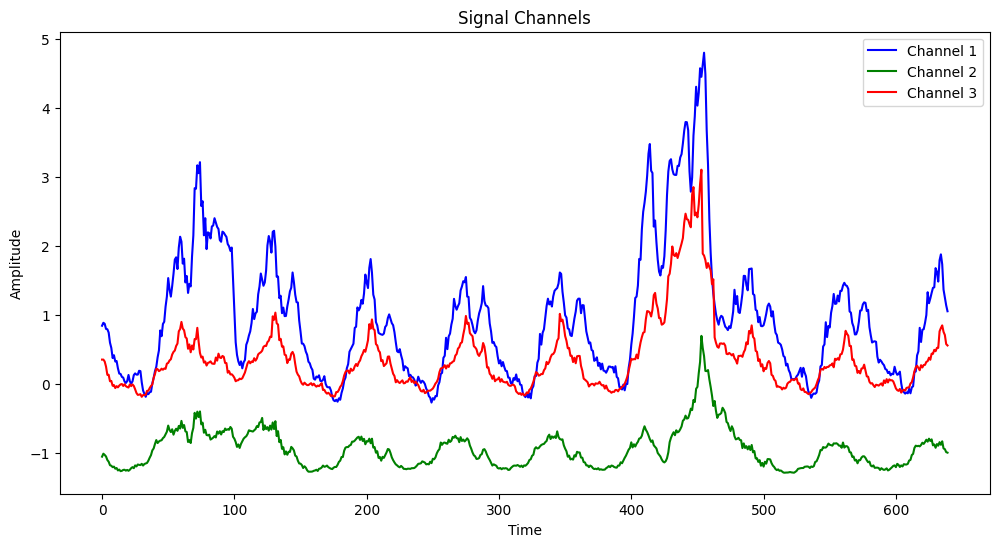

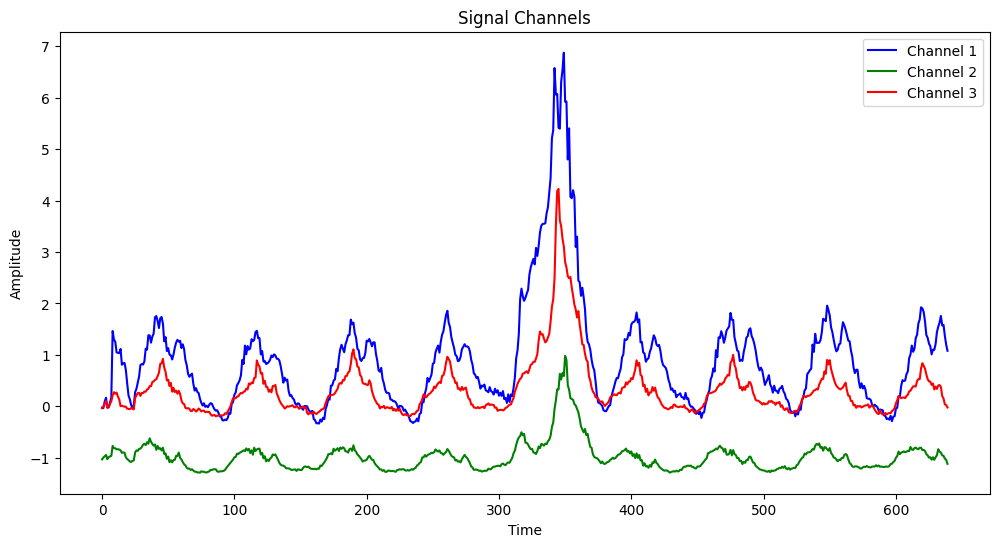

In [70]:
import matplotlib.pyplot as plt

time_axis = np.arange(window_size)
# Plot all channels in a single plot
plt.figure(figsize=(12, 6))

plt.plot(time_axis, x_train[0][:, 0], label='Channel 1', color='blue')
plt.plot(time_axis, x_train[0][:, 1], label='Channel 2', color='green')
plt.plot(time_axis, x_train[0][:, 2], label='Channel 3', color='red')

plt.title('Signal Channels')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.show()

time_axis = np.arange(window_size)
# Plot all channels in a single plot
plt.figure(figsize=(12, 6))

plt.plot(time_axis, x_train_noisy[0][:, 0], label='Channel 1', color='blue')
plt.plot(time_axis, x_train_noisy[0][:, 1], label='Channel 2', color='green')
plt.plot(time_axis, x_train_noisy[0][:, 2], label='Channel 3', color='red')

plt.title('Signal Channels')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.show()

In [71]:
## Long short-term memory ###
def lstm(n_timesteps, n_features, n_steps,  n_outputs):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu'), input_shape=(n_steps, n_timesteps // n_steps, n_features)))

    model.add(BatchNormalization())
    model.add(TimeDistributed(AveragePooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))

    model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(AveragePooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))

    model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(AveragePooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=8, kernel_size=3, activation='relu')))

    model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(AveragePooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))

    model.add(layers.LSTM(16, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(layers.LSTM(16))
    model.add(Dense(n_outputs, activation='softmax'))
    return model

In [74]:
# Create the LSTM model
model = lstm(window_size, 3, 1, 5)

In [75]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 1, 638, 512)       5120      
 ributed)                                                        
                                                                 
 batch_normalization (Batch  (None, 1, 638, 512)       2048      
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 1, 319, 512)       0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 1, 317, 128)       196736    
 stributed)                                                      
                                                                 
 batch_normalization_1 (Bat  (None, 1, 317, 128)       5

In [77]:
checkpoint_filepath = './drive/MyDrive/kursinis/Modeliai/model_LSTM_Complex_640_unf001_.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

In [90]:
model.load_weights('./drive/MyDrive/kursinis/Modeliai/model_LSTM_Complex_640_unf001_.29-0.22.h5')

In [79]:
# Reshape the input data to add an extra dimension
x_train_noisy = np.expand_dims(x_train_noisy, axis=1)
x_train_noisy.shape

(203409, 1, 640, 3)

In [80]:
# x_train_noisy = np.squeeze(x_train_noisy, axis=1)
# x_train_noisy.shape

In [81]:
x_val = np.expand_dims(x_val, axis=1)
x_val.shape

(200, 1, 640, 3)

In [82]:
# x_val = np.squeeze(x_val, axis=1)
# x_val.shape

In [83]:
x_test = np.expand_dims(x_test, axis=1)
x_test.shape

(100, 1, 640, 3)

In [84]:
# x_test = np.squeeze(x_test, axis=1)
# x_test.shape

In [85]:
# Train the model
model.fit(
    x_train_noisy,
    y_train_noisy,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=16,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
12714/12714 [==============================] - ETA: 0s - loss: 0.5122 - accuracy: 0.7892
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to ./drive/MyDrive/kursinis/Modeliai/model_LSTM_Complex_640_unf001_.01-0.96.h5
12714/12714 [==============================] - 179s 13ms/step - loss: 0.5122 - accuracy: 0.7892 - val_loss: 0.9609 - val_accuracy: 0.7000
Epoch 2/30
12710/12714 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9245
Epoch 2: val_accuracy improved from 0.70000 to 0.80500, saving model to ./drive/MyDrive/kursinis/Modeliai/model_LSTM_Complex_640_unf001_.02-0.64.h5
12714/12714 [==============================] - 164s 13ms/step - loss: 0.2140 - accuracy: 0.9245 - val_loss: 0.6379 - val_accuracy: 0.8050
Epoch 3/30
12710/12714 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9487
Epoch 3: val_accuracy improved from 0.80500 to 0.84000, saving model to ./drive/MyDrive/kursinis/Modeliai/model_LSTM_Complex_640_un

In [91]:
# Evaluate the model
model.evaluate(x_test, y_test, verbose=1)

4/4 [==============================] - 0s 16ms/step - loss: 0.4597 - accuracy: 0.9300


[0.45965155959129333, 0.9300000071525574]

In [92]:
# Evaluate the model and calculate accuracy
predictions = model.predict(x_test)

4/4 [==============================] - 0s 13ms/step


In [93]:
print(predictions.shape)
print(x_test.shape)

# Calculate accuracy for each label
rounded_predictions = np.argmax(predictions, axis=1)

# Calculate accuracy for each label
correct = np.sum(rounded_predictions == y_test)

total_samples = len(y_test)
accuracy = correct / total_samples * 100
print(f"Overall Accuracy: {accuracy:.2f}%")

(100, 5)
(100, 1, 640, 3)
Overall Accuracy: 93.00%


In [94]:
from sklearn.metrics import classification_report
unique_labels, counts = np.unique(labels_array, return_counts=True)
print("Window size:", window_size)
print("Step size:", step_size)
print()
print("Unique Labels:", unique_labels)
print("Class counts:", counts)
print("Original data:", signals_array.shape)
print()
print("Train data (No aug):", x_train.shape)
print("Val data (No aug):", x_val.shape)
print("Test data (No aug):", x_test.shape)
print()
print("Train data augmented:", x_train_noisy.shape)
print()
print(f"Test set accuracy: {accuracy:.2f}%")
print()
print(classification_report(y_test, rounded_predictions))

Window size: 640
Step size: 128

Unique Labels: [0 1 2 3 4]
Class counts: [187 189 201 213 209]
Original data: (999, 640, 3)

Train data (No aug): (699, 640, 3)
Val data (No aug): (200, 1, 640, 3)
Test data (No aug): (100, 1, 640, 3)

Train data augmented: (203409, 1, 640, 3)

Test set accuracy: 93.00%

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       0.95      1.00      0.98        21
           2       1.00      0.95      0.98        22
           3       0.84      0.89      0.86        18
           4       1.00      0.83      0.90        23

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100

